数据增广是深度学习中常用的技巧之一，主要用于增加训练数据集，让数据集尽可能的多样化，使得训练的模型具有更强的泛化能力．现有的各大深度学习框架都已经自带了数据增广，但是平时在用的使用只是直接调用了对应的接口函数，而没有进行详细的分析．在实际应用中，并非所有的增广方式都适用当前的训练数据，需要根据自己的数据集特征来确定应该使用哪几种数据增广方式．
目前数据增广主要包括：水平/垂直翻转，旋转，缩放，裁剪，剪切，平移，对比度，色彩抖动，噪声等

# 输入一张样例图像

In [19]:
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import sys
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import cv2
import copy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

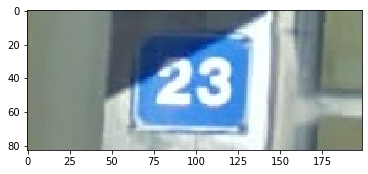

In [4]:
img=Image.open('./input/train/000001.png')
plt.imshow(img)

In [5]:
#展示经过数据增强后的图片
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

#这个函数对输入图像img多次运行图像增广方法aug并展示所有的结果。
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

# 随机水平翻转
在此处对字符串的识别不适用，因为水平翻转会改变数字，难以进行训练
通过下列可以看出水平翻转后一定程度上会影响对于这个字符串的识别，可能会达到相反的效果

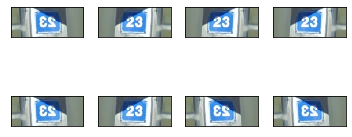

In [7]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

# 随机垂直翻转
同上

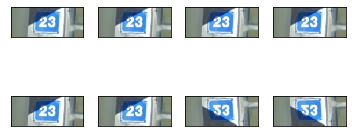

In [9]:
apply(img, torchvision.transforms.RandomVerticalFlip())

# 随机裁剪
#在下面的代码里，我们每次随机裁剪出一块面积为原面积 10%∼100% 的区域，
#且该区域的宽和高之比随机取自 0.5∼2 ，然后再将该区域的宽和高分别缩放到200像素。
#若无特殊说明，本节中 a 和 b 之间的随机数指的是从区间 [a,b] 中随机均匀采样所得到的连续值

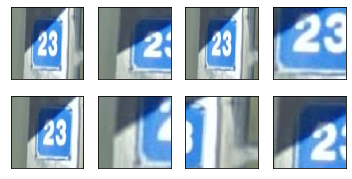

In [10]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

# 变化颜色。
#我们可以从4个方面改变图像的颜色：亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）。
#在下面的例子里，我们将图像的亮度随机变化为原图亮度的 50% ( 1−0.5 ) ∼150% ( 1+0.5 )

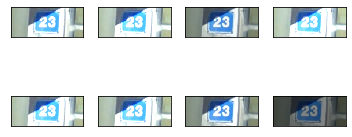

In [11]:
# 改变明亮度
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

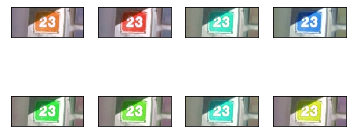

In [12]:
# 随机变化图像的色调
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

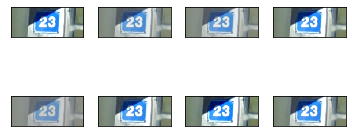

In [13]:
# 随机变化图像的对比度
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0))

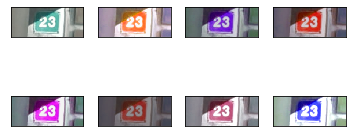

In [14]:
# 随机变化图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

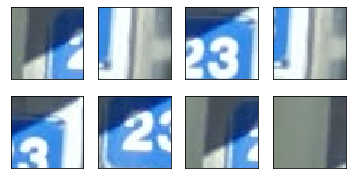

In [17]:
# 基于padding的随机裁剪，这个要设置好裁剪的超参数
padding_aug = torchvision.transforms.RandomCrop(50,padding=4)
apply(img, padding_aug)

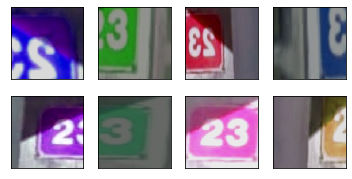

In [18]:
# 叠加多个增强方法
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

# 数据增强的类实现

In [20]:
class DataAugment:
    def __init__(self,debug=False):
        self.debug=debug
        print("Data augment...")

    def basic_matrix(self,translation):
        """基础变换矩阵"""
        return np.array([[1,0,translation[0]],[0,1,translation[1]],[0,0,1]])

    def adjust_transform_for_image(self,img,trans_matrix):
        """根据图像调整当前变换矩阵"""
        transform_matrix=copy.deepcopy(trans_matrix)
        height, width, channels = img.shape
        transform_matrix[0:2, 2] *= [width, height]
        center = np.array((0.5 * width, 0.5 * height))
        transform_matrix = np.linalg.multi_dot([self.basic_matrix(center), transform_matrix, self.basic_matrix(-center)])
        return transform_matrix

    def apply_transform(self,img,transform):
        """仿射变换"""
        output = cv2.warpAffine(img, transform[:2, :], dsize=(img.shape[1], img.shape[0]),
                                flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT, borderValue=0,)   #cv2.BORDER_REPLICATE,cv2.BORDER_TRANSPARENT
        return output

    def apply(self,img,trans_matrix):
        """应用变换"""
        tmp_matrix=self.adjust_transform_for_image(img, trans_matrix)
        out_img=self.apply_transform(img, tmp_matrix)
        if self.debug:
            self.show(out_img)
        return out_img

    def random_vector(self,min,max):
        """生成范围矩阵"""
        min=np.array(min)
        max=np.array(max)
        print(min.shape,max.shape)
        assert min.shape==max.shape
        assert len(min.shape) == 1
        return np.random.uniform(min, max)

    def show(self,img):
        """可视化"""
        cv2.imshow("outimg",img)
        cv2.waitKey()

    def random_transform(self,img,min_translation,max_translation):
        """平移变换"""
        factor=self.random_vector(min_translation,max_translation)
        trans_matrix=np.array([[1, 0, factor[0]],[0, 1, factor[1]],[0, 0, 1]])
        out_img=self.apply(img,trans_matrix)
        return trans_matrix, out_img

    def random_flip(self,img,factor):
        """水平或垂直翻转"""
        flip_matrix = np.array([[factor[0], 0, 0],[0, factor[1], 0],[0, 0, 1]])
        out_img=self.apply(img,flip_matrix)
        return flip_matrix, out_img

    def random_rotate(self,img,factor):
        """随机旋转"""
        angle=np.random.uniform(factor[0],factor[1])
        print("angle:{}".format(angle))
        rotate_matrix=np.array([[np.cos(angle), -np.sin(angle), 0],[np.sin(angle), np.cos(angle), 0],[0, 0, 1]])
        out_img=self.apply(img,rotate_matrix)
        return rotate_matrix, out_img

    def random_scale(self,img,min_translation,max_translation):
        """随机缩放"""
        factor=self.random_vector(min_translation, max_translation)
        scale_matrix = np.array([[factor[0], 0, 0],[0, factor[1], 0],[0, 0, 1]])
        out_img=self.apply(img,scale_matrix)
        return scale_matrix, out_img

    def random_shear(self,img,factor):
        """随机剪切，包括横向和众向剪切"""
        angle = np.random.uniform(factor[0], factor[1])
        print("fc:{}".format(angle))
        crop_matrix = np.array([[1, factor[0], 0], [factor[1], 1, 0], [0, 0, 1]])
        out_img=self.apply(img,crop_matrix)
        return crop_matrix, out_img

In [21]:
demo=DataAugment(debug=True)
img=cv2.imread("./input/train/000001.png")

Data augment...


In [22]:
t1,_=demo.random_transform(img,(-0.3,-0.3),(0.3,0.3))
t2,_=demo.random_rotate(img,(0.5,0.8))
t3,_=demo.random_scale(img,(1.5,1.5),(1.7,1.7))
tmp=np.linalg.multi_dot([t1,t2,t3])
print("tmp:{}".format(tmp))
out=demo.apply(img,tmp)

(2,) (2,)
angle:0.5994195383286619
(2,) (2,)
tmp:[[ 1.32420576 -0.86782268 -0.1148038 ]
 [ 0.90480994  1.27007424  0.20634508]
 [ 0.          0.          1.        ]]
